In [1]:
using Markdown
using InteractiveUtils
using CacheVariables, CairoMakie, DataFrames, DelimitedFiles, FITSIO, HTTP, Interpolations, LinearAlgebra, Printf, ProgressLogging, Statistics, StructArrays
using Logging, TerminalLoggers; global_logger(TerminalLogger());

In [2]:
WAVE = 1480:0.5:1620
k = 5
CONFIGSTR = "wave-$(replace(string(WAVE),':'=>'-')),k-$k"

"wave-1480.0-0.5-1620.0,k-5"

In [3]:
function cacheurl(url; dir="data", update_period=1)
	ispath(dir) || mkpath(dir)
	
	path = joinpath(dir, basename(url))
	ispath(path) || try
		HTTP.download(url, path; update_period)
	catch e
		ispath(path) && rm(path)
		throw(e)
	end
	
	return path
end

function loadspec(SURVEY, RUN2D, PLATE, MJD, FIBERID; dir=joinpath("data","specs"))
	url = string(
		"https://dr16.sdss.org/sas/dr16/",
		SURVEY,
		"/spectro/redux/",
		RUN2D,
		"/spectra/lite/",
		@sprintf("%04d", PLATE),
		"/spec-",
		@sprintf("%04d", PLATE),
		"-",
		MJD,
		"-",
		@sprintf("%04d", FIBERID),
		".fits"
	)
	return FITS(f -> DataFrame(f[2]), cacheurl(url; dir, update_period=Inf))
end

loadspec (generic function with 1 method)

In [4]:
Yfull, vfull = cache(joinpath("cache","data,$CONFIGSTR.bson")) do
	# Load DR16Q and form list of spectra to download
	@info "Load DR16Q and form list of spectra to download"
	DR16Q_URL = "https://data.sdss.org/sas/dr16/eboss/qso/DR16Q/DR16Q_v4.fits"
	PLATE_URL = "https://data.sdss.org/sas/dr16/sdss/spectro/redux/plates-dr16.fits"
	dr16qp = innerjoin(
		FITS(f -> DataFrame(f[2]), cacheurl(DR16Q_URL)),
		FITS(f -> DataFrame(f[2]), cacheurl(PLATE_URL));
		on=[:PLATE,:MJD], validate=(false,true), makeunique=true
	)
	list = filter(dr16qp) do spec
		spec.SURVEY == "eboss" && spec.PLATEQUALITY == "good" &&
		2.0 < spec.Z < 2.1 && spec.BAL_PROB < 0.2
	end

	# Load spectra and filter based on wavelengths covered
	@info "Load spectra and filter based on wavelengths covered"
	specs = @withprogress name="Loading spectra" map(
		1:nrow(list),
		list.SURVEY, list.RUN2D, list.PLATE, list.MJD, list.FIBERID, list.Z
	) do idx, SURVEY, RUN2D, PLATE, MJD, FIBERID, Z
		df = loadspec(SURVEY,RUN2D,PLATE,MJD,FIBERID)
		spec = (;
			WAVE = 10.0 .^ df.LOGLAM ./ (1+Z),   # Restframe wavelength
			FLUX = df.FLUX,                      # Flux
			IVAR = df.IVAR,                      # Inverse variance
		)
		@logprogress idx/nrow(list)
		return spec
	end
	specs = filter(specs) do spec
		first = findlast(<(minimum(WAVE)),spec.WAVE)
		last = findfirst(>(maximum(WAVE)),spec.WAVE)
		return !isnothing(first) && !isnothing(last) &&  # spec.WAVE covers WAVE
			!any(iszero,spec.IVAR[first:last])           # without missing entries
	end

	# Interpolate, center, normalize, and filter based on variance profiles
	@info "Interpolate, center, normalize, and filter based on variance profiles"
	normspecs = (StructArray∘map)(specs) do spec
		# Form data vectors via linear interpolation
		FLUX = LinearInterpolation(spec.WAVE, spec.FLUX).(WAVE)
		VAR  = LinearInterpolation(spec.WAVE, inv.(spec.IVAR)).(WAVE)

		# Center
		FLUX = FLUX .- mean(FLUX)

		# Normalize
		scaling = abs(mean(FLUX[1525 .< WAVE .< 1575]))
		FLUX = FLUX / scaling
		VAR  = VAR  / scaling^2
		
		return (;FLUX, VAR)
	end
	normspecs = filter(spec -> minimum(spec.VAR)/maximum(spec.VAR) > 0.4, normspecs)
	normspecs = sort(normspecs; by = spec->mean(spec.VAR))

	# Form data matrix and variance vector
	@info "Form data matrix and variance vector"
	flux = reduce(hcat,normspecs.FLUX)
	mvar = mean.(normspecs.VAR)

	return flux, mvar
end

[ Info: Loading from cache/data,wave-1480.0-0.5-1620.0,k-5.bson


([-0.7722197497363743 -0.764552223381462 … -49.80199509409918 -455.3288254407525; -0.8579004274282271 -0.6280726482041055 … 88.66159273687535 -394.17558167386585; … ; -0.6653303461837592 -0.6996349411637004 … -41.971329639268504 218.47057100941856; -0.6408595060051653 -0.6220953535021353 … 27.864700308444828 -329.57652145367933], [0.016038669981713206, 0.016305132651962075, 0.0181605814267833, 0.01998451699524257, 0.02000740124402676, 0.021582835623207276, 0.02192600850329528, 0.023268771631899644, 0.023654073091017535, 0.024660234575402402  …  1249.1785505805456, 1536.9234700906056, 1611.7269617908355, 1865.8241016055422, 2068.180716313187, 2770.1519177197824, 4132.027105231284, 6033.738309804254, 6114.633826973344, 223702.887705039])

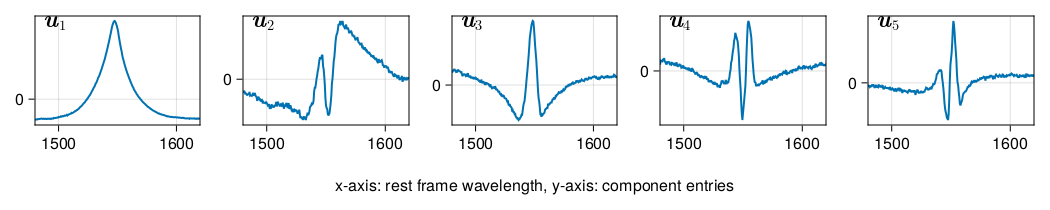

In [5]:
# Compute and plot "ground-truth" components
U = svd(Yfull[:,1:5000]).U[:,1:k]

figU = with_theme(;linewidth=2) do
	fig = Figure(;resolution=(1050,210))

	for (i,ui) in enumerate(eachcol(U))
		flip = maximum(abs,filter(>(0),ui)) < maximum(abs,filter(<(0),ui))
		ax = Axis(fig[1,i]; yticks = [0.0], xticks = [1500,1600])
		lines!(ax, WAVE, flip ? -ui : ui; linewidth=2)
		tightlimits!(ax, Left(), Right())
	end
	linkxaxes!(contents(fig.layout)...)

	for i in 1:k
		Label(fig[1,i], L"\mathbf{u}_{%$i}";
			tellheight = false, tellwidth = false, halign = :left, valign = :top,
			padding = (8,0,0,-8), fontsize = 24f0,
		)
	end
	Label(fig[end+1,:], "x-axis: rest frame wavelength, y-axis: component entries")

	fig
end

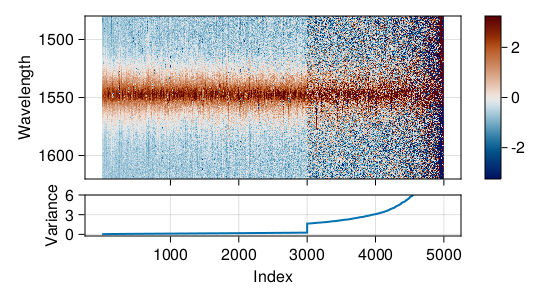

In [6]:
# Form and plot test dataset
testidx = [1:3000; length(vfull)-2000+1:length(vfull)]
Y = Yfull[:,testidx]
v = vfull[testidx]
n = length(v)

figYv = with_theme(;linewidth=2) do
	fig = Figure(;resolution=(540,300))

	axY = Axis(fig[1,1]; yreversed = true, ylabel = "Wavelength")
	hmY = heatmap!(axY, 1:n, WAVE, permutedims(Y);
		colormap = :vik, colorrange = (-1,1).*3.25)
	Colorbar(fig[1,2], hmY)

	axv = Axis(fig[2,1];
		limits = (nothing, nothing, -0.25, 6), yticks = 0:3:6,
		xlabel = "Index", ylabel = "Variance",
	)
	lines!(axv, 1:n, v)

	axY.xticks = axv.xticks = 1000:1000:5000
	linkxaxes!(axY,axv)
	hidexdecorations!(axY; ticks=false)
	rowsize!(fig.layout, 2, Relative(0.2))
	rowgap!(fig.layout, 10)
	
	fig
end
#save(joinpath("outs","sdss_data.svg"), figYv)

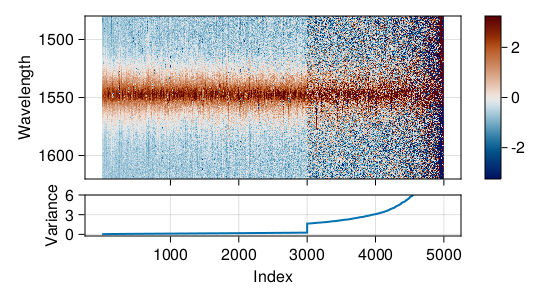

In [7]:
# Form and plot test dataset
testidx = [1:3000; length(vfull)-2000+1:length(vfull)]
Y = Yfull[:,testidx]
v = vfull[testidx]
n = length(v)

figYv = with_theme(;linewidth=2) do
	fig = Figure(;resolution=(540,300))

	axY = Axis(fig[1,1]; yreversed = true, ylabel = "Wavelength")
	hmY = heatmap!(axY, 1:n, WAVE, permutedims(Y);
		colormap = :vik, colorrange = (-1,1).*3.25)
	Colorbar(fig[1,2], hmY)

	axv = Axis(fig[2,1];
		limits = (nothing, nothing, -0.25, 6), yticks = 0:3:6,
		xlabel = "Index", ylabel = "Variance",
	)
	lines!(axv, 1:n, v)

	axY.xticks = axv.xticks = 1000:1000:5000
	linkxaxes!(axY,axv)
	hidexdecorations!(axY; ticks=false)
	rowsize!(fig.layout, 2, Relative(0.2))
	rowgap!(fig.layout, 10)
	
	fig
end
#save(joinpath("outs","sdss_data.svg"), figYv)

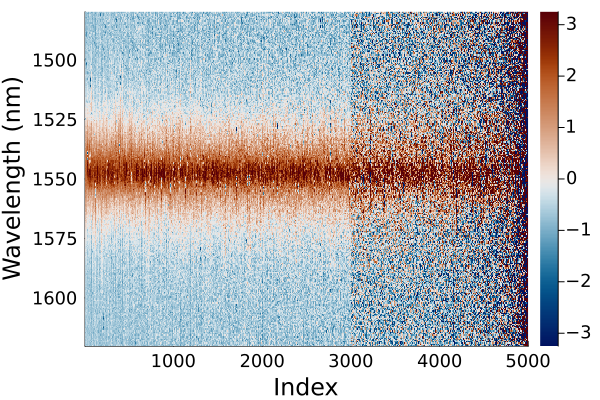

In [25]:
using Plots
Plots.heatmap(1:5000, WAVE, Y, clim = (-1,1).*3.25, colormap = :vik, yflip=true,
ylabel="Wavelength (nm)", xlabel="Index", legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=18)
#savefig("quasar_example.png")

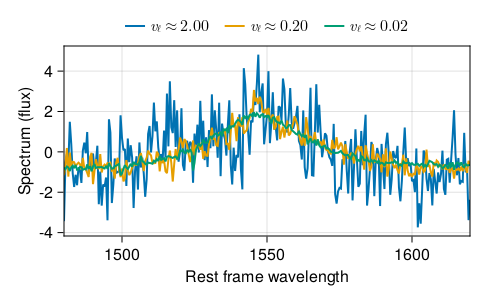

In [13]:
figspecs = with_theme(;linewidth=2) do
	fig = Figure(resolution=(486,300))
	ax = Axis(fig[1,1];
		xticks = 1500:50:1600,
		xlabel="Rest frame wavelength", ylabel="Spectrum (flux)"
	)

	for idx in [3380,2280,1]
		vstr = @sprintf("%0.2f", v[idx])
		lines!(ax, WAVE, Y[:,idx]; label=L"v_\ell \approx %$vstr")
	end
	tightlimits!(ax, Left(), Right())

	Legend(fig[0,1], ax;
		orientation = :horizontal, tellheight = true, tellwidth = false,
		framevisible = false, padding = (0,0,0,0),
	)
	rowgap!(fig.layout,10)
	fig
end

In [12]:
# Estimate signal variances

function λest_inv(Y, v)
	n, L = size.(Y,2), length(Y)
	w = [(1/v[l])/sum(n[lp]/v[lp] for lp in 1:L) for l in 1:L]
	
	Yw = reduce(hcat,sqrt(w[l])*Y[l] for l in 1:L)
	return svdvals(Yw).^2
end

Ξ(λ, v; c) = -(v+v/c-λ)/2 + sqrt((v+v/c-λ)^2-4*v^2/c)/2

function λest(Y; v)
	d, n, L = (only∘unique)(size.(Y,1)), size.(Y,2), length(Y)
	p = n./sum(n)
	
	λinv = λest_inv(Y,v)
	c = sum(n)/d
	vb = inv(sum(p[l]/v[l] for l in 1:L))

	k = count(>(vb*(1+1/sqrt(c))^2), λinv)
	return [Ξ(λinv[i],vb; c) for i in 1:k]
end

λh = λest(collect(reshape.(eachcol(Y),:,1)); v)

23-element Vector{Float64}:
 230.1056085366871
   3.9929208087147297
   3.1087157940451924
   1.2549357897642448
   1.2286372051296341
   0.8994919697625863
   0.6349661515286965
   0.5909577668405896
   0.42808698910994103
   0.3974440464421172
   0.37691414086535857
   0.33701274580742596
   0.26697618666100253
   0.23580416998903997
   0.2236075062503159
   0.21619513862610462
   0.19678265946544887
   0.14842233908514224
   0.14625049399192794
   0.1125794013933028
   0.10187678248300816
   0.09515707257619893
   0.07240388996619834

In [13]:
# Evaluate weighted PCA methods

wlist = (;
	optlim = [inv.(v.*(λh[i].+v)) for i in 1:k],
	invvar = [inv.(v) for i in 1:k],
	unweight = [fill(1,n) for i in 1:k],
)

rlist = map(wlist) do w
	r = map(1:k) do i
		Yw = Y*sqrt(Diagonal(w[i]))
		uhi = svd(Yw).U[:,i]
		return abs2(U[:,i]'uhi)
	end
end


#Rounded version
map(r -> join([@sprintf("%0.3f",ri) for ri in r]," | "), rlist)

#Approximate Orthogonality
let w=wlist[:optlim]
	Uh = map(1:k) do i
		Yw = Y*sqrt(Diagonal(w[i]))
		return svd(Yw).U[:,i]
	end |> (uh -> reduce(hcat,uh))
	maximum(abs2(Uh[:,i]'Uh[:,j]) for i in 1:k for j in 1:k if i != j)
end

0.0001305328513896407

In [14]:
# Save figure and data to files
!ispath("outs") && mkpath("outs");


save(joinpath("outs","sdss,U.png"), figU)
save(joinpath("outs","sdss,data.png"), figYv)
save(joinpath("outs","sdss,specs.png"), figspecs)

writedlm(
	joinpath("outs","sdss,rec,$CONFIGSTR.dat"),
	reduce(hcat,vcat(string(method),r) for (method,r) in pairs(rlist))
)

writedlm(
	joinpath("outs","sdss,rec,$CONFIGSTR,rounded.dat"),
	reduce(hcat,
		vcat(string(method),[@sprintf("%0.3f",ri) for ri in r])
		for (method,r) in pairs(rlist)
	)
)